<a href="https://colab.research.google.com/github/sunnys-lab/xray_classification_with_tpus/blob/main/medical_image_classification_20220628.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Medical Image Classification on Google Colab

2022-06-28 이기선

본 예제는 간단한 이미지 분류 알고리즘을 이용하여 폐엑스레이 영상을 정상과 폐렴으로 분류하는 모델을 만드는 실습입니다.

## 01. 초기설정

In [1]:
import re
import os
import random
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
AUTOTUNE = tf.data.AUTOTUNE
BATCH_SIZE = 25
IMAGE_SIZE = [180, 180]
CLASS_NAMES = ["NORMAL", "PNEUMONIA"]

## 02.데이터 로드

In [3]:
train_images = tf.data.TFRecordDataset(
    "gs://download.tensorflow.org/data/ChestXRay2017/train/images.tfrec"
)

train_paths = tf.data.TFRecordDataset(
    "gs://download.tensorflow.org/data/ChestXRay2017/train/paths.tfrec"
)

ds = tf.data.Dataset.zip((train_images, train_paths))

In [4]:
COUNT_NORMAL = len(
    [
        filename
        for filename in train_paths
        if "NORMAL" in filename.numpy().decode("utf-8")
    ]
)

print("Normal images count in training set: " + str(COUNT_NORMAL))

COUNT_PNEUMONIA = len(
    [
        filename
        for filename in train_paths
        if "PNEUMONIA" in filename.numpy().decode("utf-8")
    ]
)
print("Pneumonia images count in training set: " + str(COUNT_PNEUMONIA))

Normal images count in training set: 1349
Pneumonia images count in training set: 3883


In [5]:
def get_label(file_path):
    # 전체 파일 경로를 "/" 를 기준으로 분리
    parts = tf.strings.split(file_path, "/")
    # 분리된 파일 경로명에서 마지막 에서 두번째 부분이 class-directory 이름
    return parts[-2] == "PNEUMONIA"


def decode_img(img):
    # 스트링형태의 데이터를 3D 형태의 텐서 데이터로 변환(
    img = tf.image.decode_jpeg(img, channels=3)
    # 이미지 크기를 원하는 사이즈로 리자이징
    return tf.image.resize(img, IMAGE_SIZE)


def process_path(image, path):
    # 이미지의 라벨 확인
    label = get_label(path)
    # 스트링 형태의 로우 데이터를 이미지데이터로 변환
    img = decode_img(image)
    return img, label


ds = ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [8]:
ds = ds.shuffle(10000)
train_ds = ds.take(5000)
val_ds = ds.skip(5000)

In [9]:
for image, label in train_ds.take(5):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  True


In [10]:
test_images = tf.data.TFRecordDataset(
    "gs://download.tensorflow.org/data/ChestXRay2017/test/images.tfrec"
)
test_paths = tf.data.TFRecordDataset(
    "gs://download.tensorflow.org/data/ChestXRay2017/test/paths.tfrec"
)
test_ds = tf.data.Dataset.zip((test_images, test_paths))

test_ds = test_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

## 03. 데이터 전처리 및 시각화

In [11]:
def prepare_for_training(ds, cache=True):
    # 본 실습에서 사용하는 데이터 셋은 크기가 크지 않기 때문에,
    # 데이터셋을 메모리에 로드하여 학습을 진행 합니다.
    # `.cache(filename)` 코드는 메모리에 맞지 않는 데이터셋의 경우 
    # 전처리(preprocessing) 작업이 발생할 수 있도록 하는 코드 입니다.
    # Tensorflow Core 설명에 따르면, .cache()는 첫 번째 epoch 동안 디스크에서 
    # 이미지를 로드한 후 이미지를 메모리에 유지합니다. 이렇게 하면 모델을 
    # 훈련하는 동안 데이터세트가 병목 상태가 되지 않습니다. 데이터세트가 너무 
    # 커서 메모리에 맞지 않는 경우, 이 메서드를 사용하여 성능이 높은 온디스크 
    # 캐시를 생성할 수도 있습니다.
    if cache:
        if isinstance(cache, str):
            ds = ds.cache(cache)
        else:
            ds = ds.cache()

    ds = ds.batch(BATCH_SIZE)

    # `prefetch` 코드는 학습이 진행되는 동안 fetch 배치 작업이 백드라운드에서
    # 발생할 수 있도록 하는 코드 입니다. 
    # 버퍼 사이즈는 자동으로 설정되도록 하였습니댜.
    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

In [12]:
train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

image_batch, label_batch = next(iter(train_ds))

In [13]:
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10, 10))
    for n in range(25):
        ax = plt.subplot(5, 5, n + 1)
        plt.imshow(image_batch[n] / 255)
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")

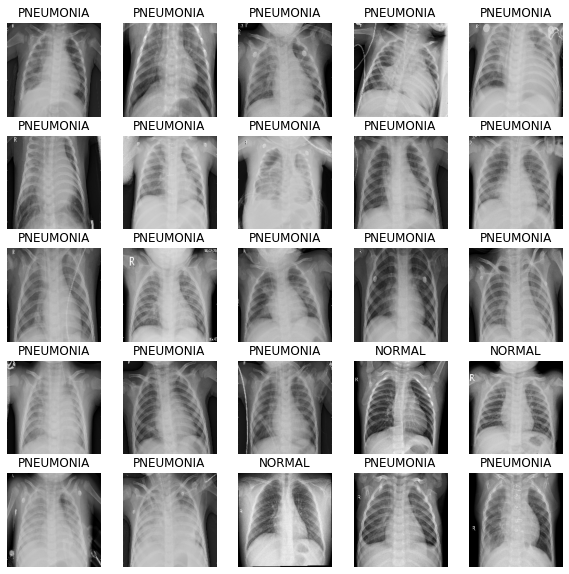

In [14]:
show_batch(image_batch.numpy(), label_batch.numpy())